In [7]:

import os
import pandas as pd


use_files = ['spam.csv', 'spam mail.csv', 'emails.csv']


available = [f for f in use_files if os.path.exists(f)]
print("Files requested:", use_files)
print("Files found in working dir:", available)
if not available:
    raise FileNotFoundError("No dataset files found. Put your CSV(s) in the notebook's working directory or edit use_files.")

def read_csv_with_fallback(path):
   
    for enc in ('utf-8','latin-1','cp1252'):
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception:
            pass
    
    return pd.read_csv(path)

def standardize_df(path):
    df = read_csv_with_fallback(path)
    cols = list(df.columns)
    cols_lower = {c.lower(): c for c in cols}

    
    label_candidates = ['v1','category','label','spam','class','target','is_spam']
    message_candidates = ['v2','masseges','message','messages','text','body','msg','message_text']

    label_col = None
    message_col = None
    for cand in label_candidates:
        if cand in cols_lower:
            label_col = cols_lower[cand]; break
    for cand in message_candidates:
        if cand in cols_lower:
            message_col = cols_lower[cand]; break

    if label_col is None or message_col is None:
        print(f"Could not auto-detect columns for file: {path}")
        print("Columns found:", cols)
        return None

    out = df[[label_col, message_col]].copy()
    out.columns = ['label', 'message']

    
    def norm_label(x):
        if pd.isna(x):
            return x
        if isinstance(x, (int, float)):
            try:
                return 'spam' if int(x) == 1 else 'ham'
            except:
                pass
        s = str(x).strip().lower()
        if s in ('1', '1.0', 'true', 't', 'spam', 's', 'yes'):
            return 'spam'
        if s in ('0', '0.0', 'false', 'f', 'ham', 'h', 'no'):
            return 'ham'
        
        if 'spam' in s:
            return 'spam'
        if 'ham' in s:
            return 'ham'
        
        return s

    out['label'] = out['label'].apply(norm_label)
    return out

dfs = []
for f in available:
    std = standardize_df(f)
    if std is None:
        
        print(f"Preview of {f}:")
        display(read_csv_with_fallback(f).head())
    else:
        dfs.append(std)

if not dfs:
    raise ValueError("No valid datasets were standardized. Check file columns and re-run.")


merged = pd.concat(dfs, ignore_index=True)
merged = merged.dropna(subset=['message', 'label']).drop_duplicates().sample(frac=1, random_state=42).reset_index(drop=True)

print("Merged dataset shape:", merged.shape)
print(merged['label'].value_counts())


display(merged.head())


merged.to_csv("merged_spam_dataset.csv", index=False)
print("Saved merged_spam_dataset.csv")

Files requested: ['spam.csv', 'spam mail.csv', 'emails.csv']
Files found in working dir: ['spam.csv', 'spam mail.csv', 'emails.csv']
Merged dataset shape: (204714, 2)
label
ham     111002
spam     93712
Name: count, dtype: int64


,label,message
0,spam,hellish report is here promoting sym chvccurre...
1,spam,take adventage promoting sym alvncurrent escap...
2,ham,http www wvbauer com downloads html has the mi...
3,spam,nomad international inc ndin a multi national ...
4,spam,welcome im girl made website feeling mood alot...


Saved merged_spam_dataset.csv


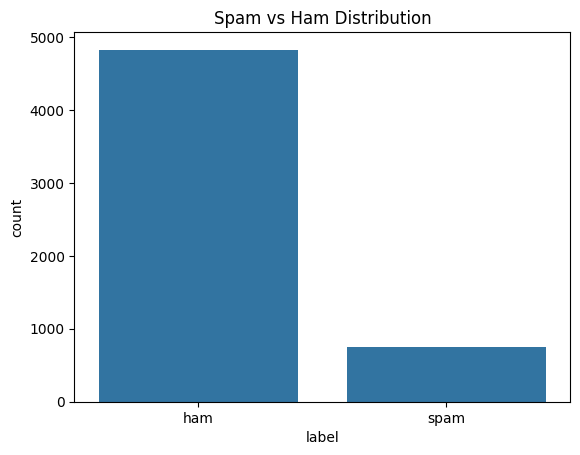

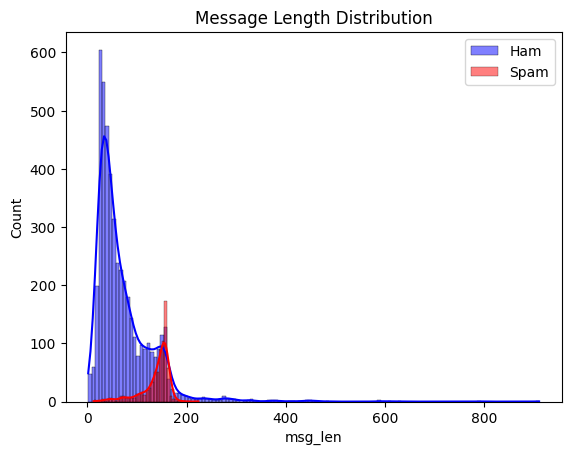

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

df['msg_len'] = df['message'].apply(len)

sns.countplot(x="label", data=df)
plt.title("Spam vs Ham Distribution")
plt.show()

sns.histplot(df[df['label']=='ham']['msg_len'], color="blue", label="Ham", kde=True)
sns.histplot(df[df['label']=='spam']['msg_len'], color="red", label="Spam", kde=True)
plt.legend()
plt.title("Message Length Distribution")
plt.show()

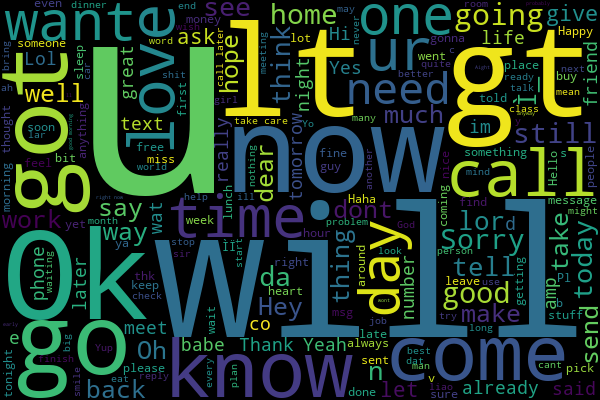

In [3]:
from wordcloud import WordCloud

spam_words = " ".join(df[df['label']=='spam']['message'])
ham_words = " ".join(df[df['label']=='ham']['message'])

WordCloud(width=600, height=400).generate(spam_words).to_image()
WordCloud(width=600, height=400).generate(ham_words).to_image()

In [4]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    return text

df['clean_msg'] = df['message'].apply(clean_text)

vectorizer = TfidfVectorizer(stop_words="english", max_features=3000)
X = vectorizer.fit_transform(df['clean_msg'])
y = df['label'].map({"ham":0, "spam":1}).values

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Naive Bayes": MultinomialNB(),
    "SVM": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"✅ Trained {name}")

✅ Trained Logistic Regression
✅ Trained Naive Bayes
✅ Trained SVM
✅ Trained Random Forest


In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n🔹 {name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Report:\n", classification_report(y_test, y_pred, target_names=["Ham","Spam"]))


🔹 Logistic Regression
Accuracy: 0.9605381165919282
Confusion Matrix:
 [[965   1]
 [ 43 106]]
Report:
               precision    recall  f1-score   support

         Ham       0.96      1.00      0.98       966
        Spam       0.99      0.71      0.83       149

    accuracy                           0.96      1115
   macro avg       0.97      0.86      0.90      1115
weighted avg       0.96      0.96      0.96      1115


🔹 Naive Bayes
Accuracy: 0.9713004484304932
Confusion Matrix:
 [[965   1]
 [ 31 118]]
Report:
               precision    recall  f1-score   support

         Ham       0.97      1.00      0.98       966
        Spam       0.99      0.79      0.88       149

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.93      1115
weighted avg       0.97      0.97      0.97      1115


🔹 SVM
Accuracy: 0.9838565022421525
Confusion Matrix:
 [[965   1]
 [ 17 132]]
Report:
               precision    recall  f1-score   support

      

In [8]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(models["Naive Bayes"], X, y, cv=5)
print("Cross Validation Accuracy:", scores.mean())

Cross Validation Accuracy: 0.973617634509021


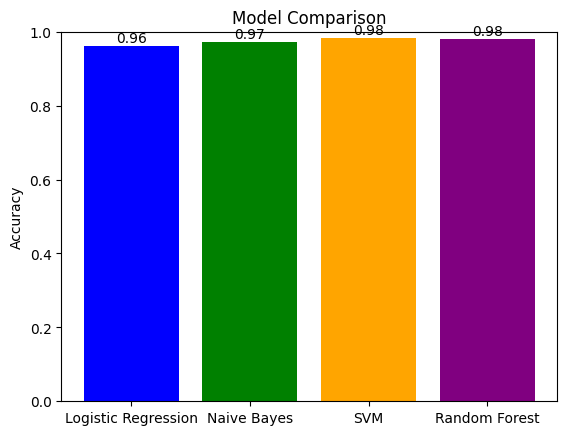

In [9]:
results = {name: model.score(X_test, y_test) for name, model in models.items()}

plt.bar(results.keys(), results.values(), color=['blue','green','orange','purple'])
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.ylim(0,1)
for i, (name, acc) in enumerate(results.items()):
    plt.text(i, acc+0.01, f"{acc:.2f}", ha='center')
plt.show()

In [10]:
import joblib

best_model = models["Naive Bayes"]
joblib.dump(best_model, "spam_classifier.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

In [11]:
import joblib


joblib.dump(best_model, "spam_classifier.pkl")


joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']